<a href="https://colab.research.google.com/github/sarim711/prediction_model/blob/main/Pathmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install medmnist

# Import libraries
from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
from sklearn.metrics import f1_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f7a45769502ff8804f011844ca3a6151766fa69290a2a29ab0b22bdad24d2936
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
INFO.keys()

dict_keys(['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d'])

In [ ]:
INFO['octmnist']

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'url_224': 'https://zenodo.org/records/10519652/files/octmnist_224.npz?downl

In [ ]:
# Data configuration
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])



In [ ]:
print(n_channels)

1


In [ ]:
# Preprocessing pipeline
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [ ]:
download = True
BATCH_SIZE = 128
# Load dataset
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

100%|██████████| 54.9M/54.9M [00:03<00:00, 15.2MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


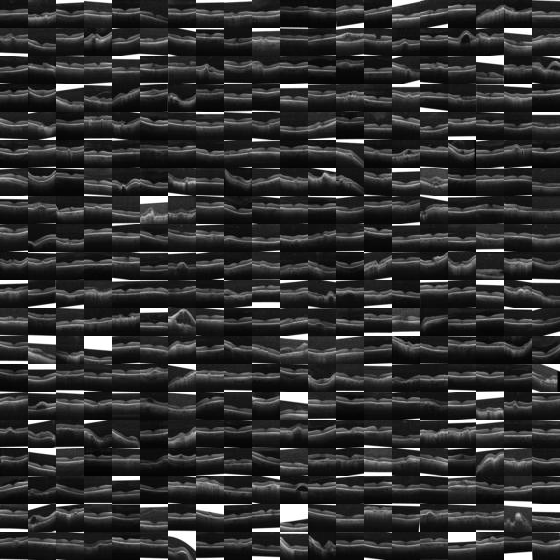

In [ ]:
train_dataset.montage(length=20)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 1000
    Root location: /root/.medmnist
   

In [ ]:
# Define CNN Model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Set Device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Loss, and Optimizer
model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train Function
def train_model(model, dataloader, criterion, optimizer, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')


In [ ]:
# Training process
train_model(model, train_loader, criterion, optimizer, num_epochs=3)

100%|██████████| 762/762 [04:24<00:00,  2.88it/s]


Epoch [1/3], Loss: 0.7457


100%|██████████| 762/762 [04:10<00:00,  3.04it/s]


Epoch [2/3], Loss: 0.6129


100%|██████████| 762/762 [04:10<00:00,  3.04it/s]

Epoch [3/3], Loss: 0.5727


In [ ]:
def evaluate_model(model, split, task='multiclass'):
    model.eval()
    # Initialize y_true and y_score on the same device as the model
    y_true = torch.tensor([]).to(device)  # Move to device
    y_score = torch.tensor([]).to(device) # Move to device
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs and targets to the same device as the model
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
    y_true = y_true.cpu().numpy()
    y_score = y_score.cpu().numpy()
    evaluator = Evaluator(data_flag, split)
    metrics = evaluator.evaluate(y_score)
    y_pred = y_score.argmax(axis=1)

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted for imbalanced datasets

    print('%s  auc: %.3f  acc:%.3f  f1:%.3f' % (split, *metrics, f1))

In [ ]:
# Evaluation
evaluate_model(model, split='train', task='multiclass')
evaluate_model(model, split='test', task='multiclass')

train  auc: 0.899  acc:0.805  f1:0.770
test  auc: 0.912  acc:0.642  f1:0.559


FINE TUNING PRE-TRAINED RESNET MODEL

In [ ]:

# Load pre-trained ResNet18 model with weights trained on ImageNet
resnet18_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet18_pretrained.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Modify the final fully connected layer to match the number of output classes
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = torch.nn.Linear(num_ftrs, n_classes)

resnet18_pretrained.to(device)

# Fine-tune all the layers
for param in resnet18_pretrained.parameters():
    param.requires_grad = True  # Unfreeze all layers for fine-tuning

# Set up criterion and optimizer
NUM_EPOCHS = 3
lr = 0.0001
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_pretrained.parameters(), lr=lr)

# Train the model
train_model(resnet18_pretrained, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

print('==> Evaluating the model on train data...')
evaluate_model(resnet18_pretrained,'train',task = 'multiclass',)

print('==> Evaluating the model on test data...')
evaluate_model(resnet18_pretrained,'test',task ='multiclass')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]
100%|██████████| 762/762 [17:52<00:00,  1.41s/it]


Epoch [1/3], Loss: 0.8697


100%|██████████| 762/762 [17:36<00:00,  1.39s/it]


Epoch [2/3], Loss: 0.6844


100%|██████████| 762/762 [17:39<00:00,  1.39s/it]


Epoch [3/3], Loss: 0.6289
==> Evaluating the model on train data...
train  auc: 0.882  acc:0.787  f1:0.749
==> Evaluating the model on test data...
test  auc: 0.904  acc:0.647  f1:0.562


TRANSFER LEARNING USING RESNET18

In [ ]:
# Load pre-trained ResNet18 model with ImageNet weights
resnet18_pretrained_2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet18_pretrained_2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#  Modify the final fully connected layer to match the number of output classes
num_ftrs = resnet18_pretrained_2.fc.in_features
resnet18_pretrained_2.fc = nn.Linear(num_ftrs, n_classes)

resnet18_pretrained_2.to(device)

#  Freeze all layers except for the final fully connected layer (classification layer)
for param in resnet18_pretrained_2.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the final fully connected layer
for param in resnet18_pretrained_2.fc.parameters():
    param.requires_grad = True  # Allow the final layer to be updated during training

#  Set up criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_pretrained_2.parameters(), lr=lr, momentum=0.9)


train_model(resnet18_pretrained_2, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

#  Evaluate the trained model
print('==> Evaluating the model on train data...')
evaluate_model(resnet18_pretrained_2, 'train', task='multiclass')

print('==> Evaluating the model on test data...')
evaluate_model(resnet18_pretrained_2, 'test', task='multiclass')


100%|██████████| 762/762 [05:11<00:00,  2.45it/s]


Epoch [1/3], Loss: 1.2368


100%|██████████| 762/762 [05:12<00:00,  2.44it/s]


Epoch [2/3], Loss: 1.1804


100%|██████████| 762/762 [05:13<00:00,  2.43it/s]


Epoch [3/3], Loss: 1.1653
==> Evaluating the model on train data...
train  auc: 0.562  acc:0.492  f1:0.430
==> Evaluating the model on test data...
test  auc: 0.563  acc:0.301  f1:0.199


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained EfficientNet-B0 model with ImageNet weights
efficientnet_pretrained = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the input layer for grayscale images (1 channel)
efficientnet_pretrained.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final fully connected layer to match the number of output classes
num_ftrs = efficientnet_pretrained.classifier[1].in_features
efficientnet_pretrained.classifier[1] = nn.Linear(num_ftrs, n_classes)

# Move model to the correct device
efficientnet_pretrained.to(device)

# Freeze all layers except the classifier
for param in efficientnet_pretrained.features.parameters():
    param.requires_grad = False

# Unfreeze only the classifier layers
for param in efficientnet_pretrained.classifier.parameters():
    param.requires_grad = True

# Set up criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_pretrained.parameters(), lr=1e-4)

# Training function
train_model(efficientnet_pretrained, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

# Evaluate the trained model
print('==> Evaluating the model on train data...')
evaluate_model(efficientnet_pretrained, 'train', task='multiclass')

print('==> Evaluating the model on test data...')
evaluate_model(efficientnet_pretrained, 'test', task='multiclass')


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 132MB/s]
100%|██████████| 762/762 [08:45<00:00,  1.45it/s]


Epoch [1/3], Loss: 1.2283


100%|██████████| 762/762 [08:40<00:00,  1.46it/s]


Epoch [2/3], Loss: 1.1692


100%|██████████| 762/762 [08:34<00:00,  1.48it/s]


Epoch [3/3], Loss: 1.1509
==> Evaluating the model on train data...
train  auc: 0.601  acc:0.538  f1:0.483
==> Evaluating the model on test data...
test  auc: 0.618  acc:0.344  f1:0.241
